# Homework 1 - EECS 600 Deep Learning

Name: Andrew Tarnoff (art81)

Instructions: All assignments are to be completed individually. Please complete each question as best you can. Once you have completed all of the problems, reset your runtime or kernel and run the notebook in order. Download the .ipynb file and submit it via Canvas.

Library usage: Several of the algorithms implemented in this, and other assignments, have implementations available in tensorflow. For this assignment, you are limited to basic operations within tensorflow and cannot use their high level APIs like tf.optimizer

All code presented in class is free to use in your assignments.

Your grade is based on the correctness of your implementation, not the quality of your code but you are encouraged to include comments in your code to help the graders understand your decisions.

For clarity, the final operation you should take is restarting the runtime and running all.

Due Date: 9/24/19 - midnight EST

100 Points Total

In [0]:
import tensorflow as tf

import random
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
tf.enable_eager_execution()

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape((x_train.shape[0], -1)).astype('float32') / 255.
x_test = x_test.reshape((x_test.shape[0], -1)).astype('float32') / 255.

y_train_encoded = tf.one_hot(y_train, 10, dtype='float32')
y_test_encoded  = tf.one_hot(y_test, 10, dtype='float32')

## Recommendation
When building and testing your code, work on a smaller subset of the data. [This example](https://stackoverflow.com/questions/14262654/numpy-get-random-set-of-rows-from-2d-array) may help in that.

### **HELPER FUNCTIONS**

In [0]:
def Train_Model(model, learning_rate, num_epochs, batch_size):
  train_loss_plot     = []
  test_loss_plot      = []
  train_accuracy_plot = []
  test_accuracy_plot  = []
  
  train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train_encoded))
  test_dataset  = tf.data.Dataset.from_tensor_slices((x_test,  y_test_encoded))

  for epoch in range(1, num_epochs + 1):
    train_batches = train_dataset.shuffle(100).batch(batch_size)

    for inp, out in train_batches:
      if learning_rate < 0:
        model.train_step(inp, out) #Accounts for using AdaDelta
      else:
        model.train_step(inp, out, learning_rate)

    train_out = model(x_train)
    test_out  = model(x_test)

    current_train_loss = loss(train_out, y_train_encoded)
    current_test_loss  = loss(test_out,  y_test_encoded)
    train_accuracy_percent = getAccuracy(y_train, train_out)*100
    test_accuracy_percent  = getAccuracy(y_test, test_out)*100

    print(f'Epoch #{epoch}: Train Loss = {current_train_loss:0.4f} : Test Loss = {current_test_loss:0.4f} : Train Accuracy = {train_accuracy_percent:0.4f}% : Test Accuracy = {test_accuracy_percent:0.4f}%\n')

    train_loss_plot.append(current_train_loss)
    test_loss_plot.append(current_test_loss)
    train_accuracy_plot.append(train_accuracy_percent)
    test_accuracy_plot.append(test_accuracy_percent)
    
  return (train_loss_plot, test_loss_plot, train_accuracy_plot, test_accuracy_plot)

In [0]:
def Plot_Loss_and_Accuracy(trainL, testL, trainA, testA):
  epoch_count = range(1, len(trainL) + 1)

  plt.figure(1)
  plt.plot(epoch_count, trainL, 'r--')
  plt.plot(epoch_count, testL, 'b-')
  plt.legend(['Training Loss', 'Test Loss'])
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.show();

  plt.figure(2)
  plt.plot(epoch_count, trainA, 'r--')
  plt.plot(epoch_count, testA, 'b-')
  plt.legend(['Training Accuracy', 'Test Accuracy'])
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy (%)')
  plt.ylim(0, 105)
  plt.show();

In [0]:
def getAccuracy(des_out, act_out_probabilities):  
  predictions = tf.argmax(act_out_probabilities, 1) #Obtains most probable guess from output layer for all inputs
  equality = tf.equal(predictions, des_out) #Boolean array for when the prediction was correct
  return len(np.where(equality)[0]) / len(equality) # Number of TRUE (equal) terms / number of Terms

In [0]:
def loss(y_hat, y):
  return tf.reduce_mean(tf.square(y_hat - y))

# Question 1
Implement a neural network with one hidden layer with 32 neurons with sigmoid activation functions and a softmax output layer with 10 outputs to classify the loaded MNIST digits as the number they represent. Each training step should be done with a batch size of 64 and the the order of the training samples should be shuffled each epoch. You may use the [tensorflow data API](https://www.tensorflow.org/beta/tutorials/load_data/numpy) to assist with that.

The loss function should me [Mean Squared Error](https://en.wikipedia.org/wiki/Mean_squared_error) between the prediction and the true results. At the end of each training epoch, the accuracy and loss value should be calculated for the whole training dataset and testing dataset. Use stochastic gradient descent as the training algorithm. Determine an effective learning rate.

In [0]:
class Model_1_layer(object):
  def __init__(self, n_input, n_hidden1, n_output):    
    # W/b between input and hidden layer #1
    self.W1 = tf.Variable(tf.random_normal([n_input, n_hidden1] , mean=0.0, stddev=0.1, dtype=tf.dtypes.float32, seed=None, name='w1'))
    self.b1 = tf.Variable(tf.random_normal([1, n_hidden1], mean=0.0, stddev=0.1, dtype=tf.dtypes.float32, seed=None, name='b1'))
    
    # W/b between hidden layer #1 and output
    self.W2 = tf.Variable(tf.random_normal([n_hidden1, n_output], mean=0.0, stddev=0.1, dtype=tf.dtypes.float32, seed=None, name='w2'))
    self.b2 = tf.Variable(tf.random_normal([1, n_output],  mean=0.0, stddev=0.1, dtype=tf.dtypes.float32, seed=None, name='b2'))
    
  def __call__(self, x):
    return self.forward(x)

  def forward(self, x):
    # Sigmoid for the first hidden layer
    a1 = tf.sigmoid(tf.linalg.matmul(x, self.W1) + self.b1)
    
    # Softmax for the output layer
    a2 = tf.nn.softmax(tf.linalg.matmul(a1, self.W2) + self.b2)
    
    return a2
  
  #Uses stochastic gradient descent
  def train_step(self, inputs, outputs, learning_rate):
    with tf.GradientTape() as t:
      current_loss = loss(self(inputs), outputs)
      dW1, dW2, db1, db2 = t.gradient(current_loss, [self.W1, self.W2, self.b1, self.b2])

    self.W1.assign_sub(learning_rate * dW1)
    self.W2.assign_sub(learning_rate * dW2)
    self.b1.assign_sub(learning_rate * db1)
    self.b2.assign_sub(learning_rate * db2)

In [8]:
# Initialize the model and start training
model = Model_1_layer(n_input=784, n_hidden1=32, n_output=10)

learning_rate = 0.5
num_epochs    = 100
batch_size    = 64

train_loss_plot_1_1, test_loss_plot_1_1, train_accuracy_plot_1_1, test_accuracy_plot_1_1 = Train_Model(model, learning_rate, num_epochs, batch_size)


Epoch #1: Train Loss = 0.0769 : Test Loss = 0.0766 : Train Accuracy = 42.2633% : Test Accuracy = 42.3200%

Epoch #2: Train Loss = 0.0504 : Test Loss = 0.0498 : Train Accuracy = 68.7767% : Test Accuracy = 69.4600%

Epoch #3: Train Loss = 0.0342 : Test Loss = 0.0335 : Train Accuracy = 81.5833% : Test Accuracy = 82.7000%

Epoch #4: Train Loss = 0.0259 : Test Loss = 0.0251 : Train Accuracy = 85.9800% : Test Accuracy = 86.8700%

Epoch #5: Train Loss = 0.0215 : Test Loss = 0.0207 : Train Accuracy = 87.7700% : Test Accuracy = 88.4000%

Epoch #6: Train Loss = 0.0190 : Test Loss = 0.0183 : Train Accuracy = 88.7650% : Test Accuracy = 89.2700%

Epoch #7: Train Loss = 0.0174 : Test Loss = 0.0167 : Train Accuracy = 89.5217% : Test Accuracy = 89.8300%

Epoch #8: Train Loss = 0.0162 : Test Loss = 0.0156 : Train Accuracy = 90.1050% : Test Accuracy = 90.3100%

Epoch #9: Train Loss = 0.0154 : Test Loss = 0.0148 : Train Accuracy = 90.5700% : Test Accuracy = 90.7600%

Epoch #10: Train Loss = 0.0147 : Test

Plot the training and testing loss and the training and testing accuracy by epoch using [matplotlib](https://chrisalbon.com/deep_learning/keras/visualize_loss_history/)

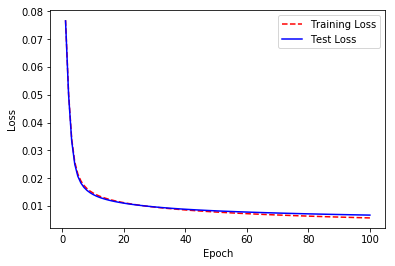

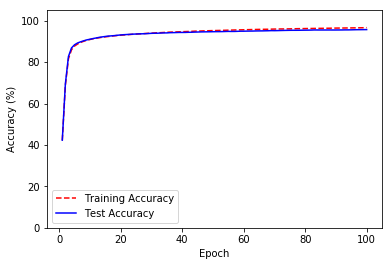

In [9]:
Plot_Loss_and_Accuracy(train_loss_plot_1_1, test_loss_plot_1_1, train_accuracy_plot_1_1, test_accuracy_plot_1_1)

## Question 1 Part 2
Change the size of your hidden layer to 16 neurons and re-run the training.

In [10]:
# Initialize the model and start training
model = Model_1_layer(n_input=784, n_hidden1=16, n_output=10)

learning_rate = 0.5
num_epochs    = 100
batch_size    = 64

train_loss_plot_1_2, test_loss_plot_1_2, train_accuracy_plot_1_2, test_accuracy_plot_1_2 = Train_Model(model, learning_rate, num_epochs, batch_size)

Epoch #1: Train Loss = 0.0836 : Test Loss = 0.0836 : Train Accuracy = 33.2817% : Test Accuracy = 32.7900%

Epoch #2: Train Loss = 0.0647 : Test Loss = 0.0645 : Train Accuracy = 50.4717% : Test Accuracy = 50.8400%

Epoch #3: Train Loss = 0.0494 : Test Loss = 0.0491 : Train Accuracy = 70.3017% : Test Accuracy = 70.7500%

Epoch #4: Train Loss = 0.0370 : Test Loss = 0.0364 : Train Accuracy = 78.3133% : Test Accuracy = 78.8300%

Epoch #5: Train Loss = 0.0290 : Test Loss = 0.0283 : Train Accuracy = 84.1800% : Test Accuracy = 84.7900%

Epoch #6: Train Loss = 0.0240 : Test Loss = 0.0233 : Train Accuracy = 87.1550% : Test Accuracy = 87.5200%

Epoch #7: Train Loss = 0.0209 : Test Loss = 0.0204 : Train Accuracy = 88.3417% : Test Accuracy = 88.4300%

Epoch #8: Train Loss = 0.0190 : Test Loss = 0.0185 : Train Accuracy = 89.0367% : Test Accuracy = 89.0600%

Epoch #9: Train Loss = 0.0176 : Test Loss = 0.0172 : Train Accuracy = 89.6717% : Test Accuracy = 89.6100%

Epoch #10: Train Loss = 0.0166 : Test

Plot the training and testing loss and the training and testing accuracy by epoch using [matplotlib](https://chrisalbon.com/deep_learning/keras/visualize_loss_history/)



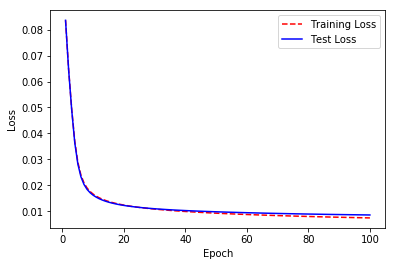

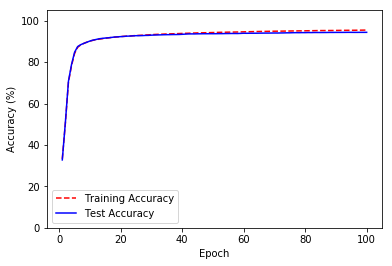

In [11]:
Plot_Loss_and_Accuracy(train_loss_plot_1_2, test_loss_plot_1_2, train_accuracy_plot_1_2, test_accuracy_plot_1_2)

##Question 1 Part 3
Change your network architecture to have two hidden layers each of size 16 and re-run the training

In [0]:
class Model_2_layer(object):
  def __init__(self, n_input, n_hidden1, n_hidden2, n_output):    
    # W/b between input and hidden layer #1
    self.W1 = tf.Variable(tf.random_normal([n_input, n_hidden1] , mean=0.0, stddev=0.1, dtype=tf.dtypes.float32, seed=None, name='w1'))
    self.b1 = tf.Variable(tf.random_normal([1, n_hidden1], mean=0.0, stddev=0.1, dtype=tf.dtypes.float32, seed=None, name='b1'))
    
    # W/b between hidden layer #1 and hidden layer #2
    self.W2 = tf.Variable(tf.random_normal([n_hidden1, n_hidden2] , mean=0.0, stddev=0.1, dtype=tf.dtypes.float32, seed=None, name='w2'))
    self.b2 = tf.Variable(tf.random_normal([1, n_hidden2], mean=0.0, stddev=0.1, dtype=tf.dtypes.float32, seed=None, name='b2'))
    
    # W/b between hidden layer #1 and output
    self.W3 = tf.Variable(tf.random_normal([n_hidden2, n_output], mean=0.0, stddev=0.1, dtype=tf.dtypes.float32, seed=None, name='w3'))
    self.b3 = tf.Variable(tf.random_normal([1, n_output],  mean=0.0, stddev=0.1, dtype=tf.dtypes.float32, seed=None, name='b3'))
    
  def __call__(self, x):
    return self.forward(x)

  def forward(self, x):
    # Sigmoid for hidden layer #1
    a1 = tf.sigmoid(tf.linalg.matmul(x, self.W1) + self.b1)
    
    # Sigmoid for hidden layer #2
    a2 = tf.sigmoid(tf.linalg.matmul(a1, self.W2) + self.b2)
    
    # Softmax for the output layer
    a3 = tf.nn.softmax(tf.linalg.matmul(a2, self.W3) + self.b3)
    
    return a3

  #Uses stochastic gradient descent
  def train_step(self, inputs, outputs, learning_rate):
    with tf.GradientTape() as t:
      current_loss = loss(model(inputs), outputs)
      dW1, dW2, dW3, db1, db2, db3 = t.gradient(current_loss, [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3])

    self.W1.assign_sub(learning_rate * dW1)
    self.W2.assign_sub(learning_rate * dW2)
    self.W3.assign_sub(learning_rate * dW3)
    self.b1.assign_sub(learning_rate * db1)
    self.b2.assign_sub(learning_rate * db2)
    self.b3.assign_sub(learning_rate * db3)

In [13]:
# Initialize the model and start training
model = Model_2_layer(n_input=784, n_hidden1=16, n_hidden2=16, n_output=10)

learning_rate = 0.5
num_epochs    = 100
batch_size    = 64

train_loss_plot_1_3, test_loss_plot_1_3, train_accuracy_plot_1_3, test_accuracy_plot_1_3 = Train_Model(model, learning_rate, num_epochs, batch_size)

Epoch #1: Train Loss = 0.0900 : Test Loss = 0.0899 : Train Accuracy = 11.2417% : Test Accuracy = 11.3600%

Epoch #2: Train Loss = 0.0899 : Test Loss = 0.0899 : Train Accuracy = 11.4767% : Test Accuracy = 11.6600%

Epoch #3: Train Loss = 0.0898 : Test Loss = 0.0898 : Train Accuracy = 11.8267% : Test Accuracy = 11.9700%

Epoch #4: Train Loss = 0.0897 : Test Loss = 0.0897 : Train Accuracy = 13.1483% : Test Accuracy = 13.2100%

Epoch #5: Train Loss = 0.0895 : Test Loss = 0.0895 : Train Accuracy = 14.5033% : Test Accuracy = 14.5700%

Epoch #6: Train Loss = 0.0891 : Test Loss = 0.0891 : Train Accuracy = 15.4133% : Test Accuracy = 15.2900%

Epoch #7: Train Loss = 0.0878 : Test Loss = 0.0877 : Train Accuracy = 16.7733% : Test Accuracy = 16.7800%

Epoch #8: Train Loss = 0.0836 : Test Loss = 0.0834 : Train Accuracy = 21.0750% : Test Accuracy = 20.8600%

Epoch #9: Train Loss = 0.0805 : Test Loss = 0.0802 : Train Accuracy = 32.6600% : Test Accuracy = 32.5400%

Epoch #10: Train Loss = 0.0790 : Test

Plot the training and testing loss and the training and testing accuracy by epoch using [matplotlib](https://chrisalbon.com/deep_learning/keras/visualize_loss_history/)
![alt text](https://)

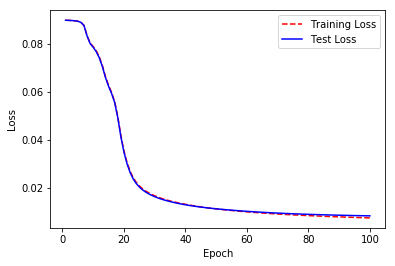

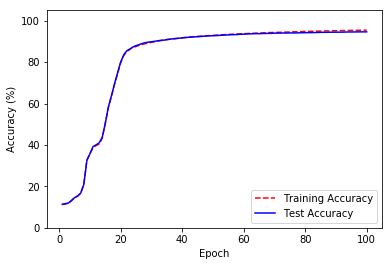

In [14]:
Plot_Loss_and_Accuracy(train_loss_plot_1_3, test_loss_plot_1_3, train_accuracy_plot_1_3, test_accuracy_plot_1_3)

## Question 1 Part 4
Change the activation functions in the hidden layer to ReLU and re-run the training

In [0]:
class Model_2_layer_ReLU(object):
  def __init__(self, n_input, n_hidden1, n_hidden2, n_output):    
    # W/b between input and hidden layer #1
    self.W1 = tf.Variable(tf.random_normal([n_input, n_hidden1] , mean=0.0, stddev=0.1, dtype=tf.dtypes.float32, seed=None, name='w1'))
    self.b1 = tf.Variable(tf.random_normal([1, n_hidden1], mean=0.0, stddev=0.1, dtype=tf.dtypes.float32, seed=None, name='b1'))
    
    # W/b between hidden layer #1 and hidden layer #2
    self.W2 = tf.Variable(tf.random_normal([n_hidden1, n_hidden2] , mean=0.0, stddev=0.1, dtype=tf.dtypes.float32, seed=None, name='w2'))
    self.b2 = tf.Variable(tf.random_normal([1, n_hidden2], mean=0.0, stddev=0.1, dtype=tf.dtypes.float32, seed=None, name='b2'))
    
    # W/b between hidden layer #1 and output
    self.W3 = tf.Variable(tf.random_normal([n_hidden2, n_output], mean=0.0, stddev=0.1, dtype=tf.dtypes.float32, seed=None, name='w3'))
    self.b3 = tf.Variable(tf.random_normal([1, n_output],  mean=0.0, stddev=0.1, dtype=tf.dtypes.float32, seed=None, name='b3'))
    
  def __call__(self, x):
    return self.forward(x)

  def forward(self, x):
    # ReLu for hidden layer #1
    a1 = tf.nn.relu(tf.linalg.matmul(x, self.W1) + self.b1)
    
    # ReLu  for hidden layer #2
    a2 = tf.nn.relu(tf.linalg.matmul(a1, self.W2) + self.b2)
    
    # Softmax for the output layer
    a3 = tf.nn.softmax(tf.linalg.matmul(a2, self.W3) + self.b3)
    
    return a3

  #Uses stochastic gradient descent
  def train_step(self, inputs, outputs, learning_rate):
    with tf.GradientTape() as t:
      current_loss = loss(model(inputs), outputs)
      dW1, dW2, dW3, db1, db2, db3 = t.gradient(current_loss, [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3])

    self.W1.assign_sub(learning_rate * dW1)
    self.W2.assign_sub(learning_rate * dW2)
    self.W3.assign_sub(learning_rate * dW3)
    self.b1.assign_sub(learning_rate * db1)
    self.b2.assign_sub(learning_rate * db2)
    self.b3.assign_sub(learning_rate * db3)

In [16]:
# Initialize the model and start training
model = Model_2_layer_ReLU(n_input=784, n_hidden1=16, n_hidden2=16, n_output=10)

learning_rate = 0.5
num_epochs    = 100
batch_size    = 64

train_loss_plot_1_4, test_loss_plot_1_4, train_accuracy_plot_1_4, test_accuracy_plot_1_4 = Train_Model(model, learning_rate, num_epochs, batch_size)

Epoch #1: Train Loss = 0.0611 : Test Loss = 0.0607 : Train Accuracy = 55.6567% : Test Accuracy = 55.6000%

Epoch #2: Train Loss = 0.0208 : Test Loss = 0.0200 : Train Accuracy = 86.0733% : Test Accuracy = 86.9100%

Epoch #3: Train Loss = 0.0162 : Test Loss = 0.0155 : Train Accuracy = 89.3567% : Test Accuracy = 89.9500%

Epoch #4: Train Loss = 0.0147 : Test Loss = 0.0142 : Train Accuracy = 90.3683% : Test Accuracy = 90.6300%

Epoch #5: Train Loss = 0.0137 : Test Loss = 0.0134 : Train Accuracy = 91.0733% : Test Accuracy = 91.1800%

Epoch #6: Train Loss = 0.0127 : Test Loss = 0.0126 : Train Accuracy = 91.7833% : Test Accuracy = 91.8200%

Epoch #7: Train Loss = 0.0119 : Test Loss = 0.0119 : Train Accuracy = 92.3333% : Test Accuracy = 92.2100%

Epoch #8: Train Loss = 0.0117 : Test Loss = 0.0118 : Train Accuracy = 92.4483% : Test Accuracy = 92.2600%

Epoch #9: Train Loss = 0.0114 : Test Loss = 0.0117 : Train Accuracy = 92.6667% : Test Accuracy = 92.3000%

Epoch #10: Train Loss = 0.0109 : Test

Plot the training and testing loss and the training and testing accuracy by epoch using [matplotlib](https://chrisalbon.com/deep_learning/keras/visualize_loss_history/)


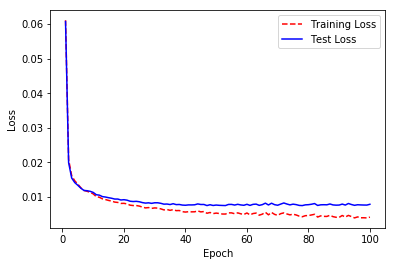

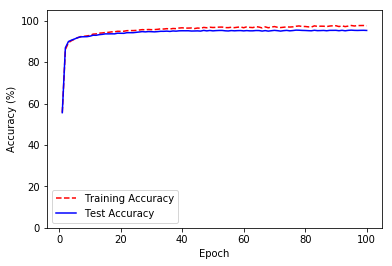

In [17]:
Plot_Loss_and_Accuracy(train_loss_plot_1_4, test_loss_plot_1_4, train_accuracy_plot_1_4, test_accuracy_plot_1_4)

## Question 1 part 5
***Describe how changing the size of the hidden layer and the number of hidden layers impacted the predictions of the network.***

Changing the number of neurons on the hidden layer from 32 to 16  caused the generalizability of the trained model to go up. This makes sense because since your model is less complex it will be less likely to grab on to details that are specific to the test dataset. A downside of this change could also be that the accuracy of your model goes down since the model is less complex however I did not see this in my results.



Changing the number of hidden layers from 1 to 2 (16 neurons in each layer) didn't seem to change the results that much in terms of generalizability but continuing to increase the complexity will eventually lead to overfitting and the model will not work very well for datasets that are much different from the one used in training. It is also noted that the 2 layer model had a significantly lower final accuracy (after 100 epochs); however, I'm not sure why something like this would happen.

# Question 2 Part 1

Re-use the network built above but modify the update step to the following.

\begin{align}
V_t = \beta V_{t-1} + (1-\beta)g_t \\
W_{t+1} = W_t - \alpha V_t
\end{align}

where $V_t$ is the update vector for step $t$. Use $\beta=0.1$.

In [0]:
class Model_2_layer_ReLU_w_Momentum(object):
  def __init__(self, n_input, n_hidden1, n_hidden2, n_output, beta):    
    # W/b between input and hidden layer #1
    self.W1 = tf.Variable(tf.random_normal([n_input, n_hidden1] , mean=0.0, stddev=0.1, dtype=tf.dtypes.float32, seed=None, name='w1'))
    self.b1 = tf.Variable(tf.random_normal([1, n_hidden1], mean=0.0, stddev=0.1, dtype=tf.dtypes.float32, seed=None, name='b1'))
    
    # W/b between hidden layer #1 and hidden layer #2
    self.W2 = tf.Variable(tf.random_normal([n_hidden1, n_hidden2] , mean=0.0, stddev=0.1, dtype=tf.dtypes.float32, seed=None, name='w2'))
    self.b2 = tf.Variable(tf.random_normal([1, n_hidden2], mean=0.0, stddev=0.1, dtype=tf.dtypes.float32, seed=None, name='b2'))
    
    # W/b between hidden layer #1 and output
    self.W3 = tf.Variable(tf.random_normal([n_hidden2, n_output], mean=0.0, stddev=0.1, dtype=tf.dtypes.float32, seed=None, name='w3'))
    self.b3 = tf.Variable(tf.random_normal([1, n_output],  mean=0.0, stddev=0.1, dtype=tf.dtypes.float32, seed=None, name='b3'))
    
    self.beta = beta
    self.prevGradient = [0, 0, 0, 0, 0, 0]
    
  def __call__(self, x):
    return self.forward(x)

  def forward(self, x):
    # Sigmoid for hidden layer #1
    a1 = tf.nn.relu(tf.linalg.matmul(x, self.W1) + self.b1)
    
    # Sigmoid for hidden layer #2
    a2 = tf.nn.relu(tf.linalg.matmul(a1, self.W2) + self.b2)
    
    # Softmax for the output layer
    a3 = tf.nn.softmax(tf.linalg.matmul(a2, self.W3) + self.b3)
    
    return a3

  #Uses stochastic gradient descent
  def train_step(self, inputs, outputs, learning_rate):
    with tf.GradientTape() as t:
      current_loss = loss(model(inputs), outputs)
      
      dW1, dW2, dW3, db1, db2, db3 = t.gradient(current_loss, [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3])
      dW1_p, dW2_p, dW3_p, db1_p, db2_p, db3_p = self.prevGradient
      self.prevGradient = (dW1, dW2, dW3, db1, db2, db3) #Set the previous gradient for the next iteration to the current gradient
      
      dW1 = ((1 - self.beta) * dW1) + (self.beta * dW1_p)
      dW2 = ((1 - self.beta) * dW2) + (self.beta * dW2_p)
      dW3 = ((1 - self.beta) * dW3) + (self.beta * dW3_p)
      db1 = ((1 - self.beta) * db1) + (self.beta * db1_p)
      db2 = ((1 - self.beta) * db2) + (self.beta * db2_p)
      db3 = ((1 - self.beta) * db3) + (self.beta * db3_p)

    self.W1.assign_sub(learning_rate * dW1)
    self.W2.assign_sub(learning_rate * dW2)
    self.W3.assign_sub(learning_rate * dW3)
    self.b1.assign_sub(learning_rate * db1)
    self.b2.assign_sub(learning_rate * db2)
    self.b3.assign_sub(learning_rate * db3)

In [19]:
# Initialize the model and start training
model = Model_2_layer_ReLU_w_Momentum(n_input=784, n_hidden1=16, n_hidden2=16, n_output=10, beta=0.1)

learning_rate = 0.5
num_epochs    = 100
batch_size    = 64

train_loss_plot_2_1, test_loss_plot_2_1, train_accuracy_plot_2_1, test_accuracy_plot_2_1 = Train_Model(model, learning_rate, num_epochs, batch_size)

Epoch #1: Train Loss = 0.0537 : Test Loss = 0.0535 : Train Accuracy = 57.4500% : Test Accuracy = 57.4800%

Epoch #2: Train Loss = 0.0224 : Test Loss = 0.0217 : Train Accuracy = 84.9567% : Test Accuracy = 85.4500%

Epoch #3: Train Loss = 0.0181 : Test Loss = 0.0179 : Train Accuracy = 87.9717% : Test Accuracy = 88.1400%

Epoch #4: Train Loss = 0.0161 : Test Loss = 0.0161 : Train Accuracy = 89.3217% : Test Accuracy = 89.3600%

Epoch #5: Train Loss = 0.0148 : Test Loss = 0.0150 : Train Accuracy = 90.3350% : Test Accuracy = 90.1400%

Epoch #6: Train Loss = 0.0139 : Test Loss = 0.0142 : Train Accuracy = 90.9250% : Test Accuracy = 90.6700%

Epoch #7: Train Loss = 0.0137 : Test Loss = 0.0142 : Train Accuracy = 91.1383% : Test Accuracy = 90.6700%

Epoch #8: Train Loss = 0.0128 : Test Loss = 0.0133 : Train Accuracy = 91.7467% : Test Accuracy = 91.2400%

Epoch #9: Train Loss = 0.0119 : Test Loss = 0.0123 : Train Accuracy = 92.3533% : Test Accuracy = 91.8800%

Epoch #10: Train Loss = 0.0115 : Test

Plot the training and testing loss and the training and testing accuracy by epoch using [matplotlib](https://chrisalbon.com/deep_learning/keras/visualize_loss_history/)


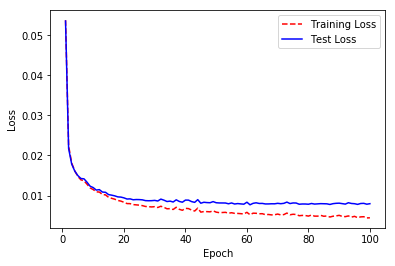

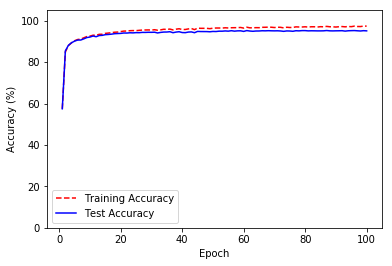

In [20]:
Plot_Loss_and_Accuracy(train_loss_plot_2_1, test_loss_plot_2_1, train_accuracy_plot_2_1, test_accuracy_plot_2_1)

## Question 2 part 2
Re-run the training with $\beta=0.9$

In [21]:
# Initialize the model and start training
model = Model_2_layer_ReLU_w_Momentum(n_input=784, n_hidden1=16, n_hidden2=16, n_output=10, beta=0.9)

learning_rate = 0.5
num_epochs    = 100
batch_size    = 64

train_loss_plot_2_2, test_loss_plot_2_2, train_accuracy_plot_2_2, test_accuracy_plot_2_2 = Train_Model(model, learning_rate, num_epochs, batch_size)

Epoch #1: Train Loss = 0.0460 : Test Loss = 0.0452 : Train Accuracy = 68.6683% : Test Accuracy = 68.9000%

Epoch #2: Train Loss = 0.0213 : Test Loss = 0.0203 : Train Accuracy = 85.6500% : Test Accuracy = 86.4000%

Epoch #3: Train Loss = 0.0171 : Test Loss = 0.0165 : Train Accuracy = 88.5900% : Test Accuracy = 88.9300%

Epoch #4: Train Loss = 0.0154 : Test Loss = 0.0149 : Train Accuracy = 89.7450% : Test Accuracy = 90.1100%

Epoch #5: Train Loss = 0.0140 : Test Loss = 0.0135 : Train Accuracy = 90.7300% : Test Accuracy = 91.1000%

Epoch #6: Train Loss = 0.0126 : Test Loss = 0.0121 : Train Accuracy = 91.7517% : Test Accuracy = 92.1400%

Epoch #7: Train Loss = 0.0122 : Test Loss = 0.0118 : Train Accuracy = 92.0417% : Test Accuracy = 92.2000%

Epoch #8: Train Loss = 0.0112 : Test Loss = 0.0108 : Train Accuracy = 92.7717% : Test Accuracy = 92.9100%

Epoch #9: Train Loss = 0.0107 : Test Loss = 0.0104 : Train Accuracy = 93.0183% : Test Accuracy = 93.3600%

Epoch #10: Train Loss = 0.0103 : Test

Plot the training and testing loss and the training and testing accuracy by epoch using [matplotlib](https://chrisalbon.com/deep_learning/keras/visualize_loss_history/)


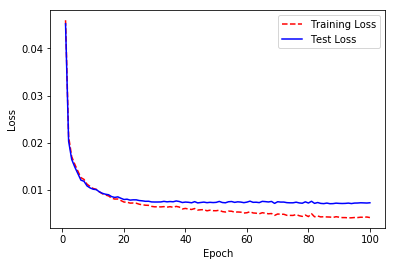

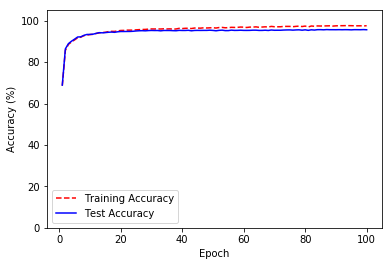

In [22]:
Plot_Loss_and_Accuracy(train_loss_plot_2_2, test_loss_plot_2_2, train_accuracy_plot_2_2, test_accuracy_plot_2_2)

## Question 2 Part 3
***Describe the differences in training results comparing the different values of $\beta$.***

For beta = 0.1 it can be seen that loss/accuracy function of the model is smoother/less volatile than for beta = 0.9. This seems to make sense to me since the beta value determines what percentage of the previous gradient is averaged with the current gradient. If this value is high (0.9) this means that the gradient used for the current step is heavily dependant on the gradient from the previous step thereby making the deterioration of the gradient (and therefore how quickly the model "settles") happen slower.

## Question 2 Part 4
Re-use the network above, but implement the [AdaDelta](http://ruder.io/optimizing-gradient-descent/index.html#adadelta) learning algorithm. You can assume an initial value of $RMS[\nabla \theta]_{t-1} = 1.0$

In [0]:
def runningDecayAvg_w_initial_value(prevAvg, nextValue, init, gamma):
  if isinstance(prevAvg, int):
    return init
  decay_avg = gamma*(prevAvg) + ((1 - gamma)*(tf.square(nextValue)))
  return decay_avg

class Model_2_layer_ReLU_w_AdaDelta(object):
  def __init__(self, n_input, n_hidden1, n_hidden2, n_output, gamma, epsilon):    
    # W/b between input and hidden layer #1
    self.W1 = tf.Variable(tf.random_normal([n_input, n_hidden1] , mean=0.0, stddev=0.1, dtype=tf.dtypes.float32, seed=None, name='w1'))
    self.b1 = tf.Variable(tf.random_normal([1, n_hidden1], mean=0.0, stddev=0.1, dtype=tf.dtypes.float32, seed=None, name='b1'))
    
    # W/b between hidden layer #1 and hidden layer #2
    self.W2 = tf.Variable(tf.random_normal([n_hidden1, n_hidden2] , mean=0.0, stddev=0.1, dtype=tf.dtypes.float32, seed=None, name='w2'))
    self.b2 = tf.Variable(tf.random_normal([1, n_hidden2], mean=0.0, stddev=0.1, dtype=tf.dtypes.float32, seed=None, name='b2'))
    
    # W/b between hidden layer #1 and output
    self.W3 = tf.Variable(tf.random_normal([n_hidden2, n_output], mean=0.0, stddev=0.1, dtype=tf.dtypes.float32, seed=None, name='w3'))
    self.b3 = tf.Variable(tf.random_normal([1, n_output],  mean=0.0, stddev=0.1, dtype=tf.dtypes.float32, seed=None, name='b3'))
    
    # Variables to hold info needed for AdaDelta
    self.gamma   = gamma
    self.epsilon = epsilon
    
    self.avg_square_gradients_W1 = 0
    self.avg_square_gradients_W2 = 0
    self.avg_square_gradients_W3 = 0
    self.avg_square_gradients_b1 = 0
    self.avg_square_gradients_b2 = 0
    self.avg_square_gradients_b3 = 0
    
    self.avg_square_updates_W1 = 0
    self.avg_square_updates_W2 = 0
    self.avg_square_updates_W3 = 0
    self.avg_square_updates_b1 = 0
    self.avg_square_updates_b2 = 0
    self.avg_square_updates_b3 = 0
    
  def __call__(self, x):
    return self.forward(x)

  def forward(self, x):
    # Sigmoid for hidden layer #1
    a1 = tf.nn.relu(tf.linalg.matmul(x, self.W1) + self.b1)
    
    # Sigmoid for hidden layer #2
    a2 = tf.nn.relu(tf.linalg.matmul(a1, self.W2) + self.b2)
    
    # Softmax for the output layer
    a3 = tf.nn.softmax(tf.linalg.matmul(a2, self.W3) + self.b3)
    
    return a3

  def train_step(self, inputs, outputs):
    with tf.GradientTape() as t:
      current_loss = loss(model(inputs), outputs)
      
      dW1, dW2, dW3, db1, db2, db3 = t.gradient(current_loss, [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3])
      
      # Calculating the avg of the squares of all previous gradients where
      # initial value is the square of the first gradient
      self.avg_square_gradients_W1 = runningDecayAvg_w_initial_value(self.avg_square_gradients_W1, dW1, tf.square(dW1), self.gamma)
      self.avg_square_gradients_W2 = runningDecayAvg_w_initial_value(self.avg_square_gradients_W2, dW2, tf.square(dW2), self.gamma)
      self.avg_square_gradients_W3 = runningDecayAvg_w_initial_value(self.avg_square_gradients_W3, dW3, tf.square(dW3), self.gamma)
      self.avg_square_gradients_b1 = runningDecayAvg_w_initial_value(self.avg_square_gradients_b1, db1, tf.square(db1), self.gamma)
      self.avg_square_gradients_b2 = runningDecayAvg_w_initial_value(self.avg_square_gradients_b2, db2, tf.square(db2), self.gamma)
      self.avg_square_gradients_b3 = runningDecayAvg_w_initial_value(self.avg_square_gradients_b3, db3, tf.square(db3), self.gamma)
      
      #Calculate separate learning rates per parameter
      self.update_W1 = tf.sqrt(self.avg_square_updates_W1 + self.epsilon) * dW1 / tf.sqrt(self.avg_square_gradients_W1 + self.epsilon)
      self.update_W2 = tf.sqrt(self.avg_square_updates_W2 + self.epsilon) * dW2 / tf.sqrt(self.avg_square_gradients_W2 + self.epsilon)
      self.update_W3 = tf.sqrt(self.avg_square_updates_W3 + self.epsilon) * dW3 / tf.sqrt(self.avg_square_gradients_W3 + self.epsilon)
      self.update_b1 = tf.sqrt(self.avg_square_updates_b1 + self.epsilon) * db1 / tf.sqrt(self.avg_square_gradients_b1 + self.epsilon)
      self.update_b2 = tf.sqrt(self.avg_square_updates_b2 + self.epsilon) * db2 / tf.sqrt(self.avg_square_gradients_b2 + self.epsilon)
      self.update_b3 = tf.sqrt(self.avg_square_updates_b3 + self.epsilon) * db3 / tf.sqrt(self.avg_square_gradients_b3 + self.epsilon)
      
      self.avg_square_updates_W1 = runningDecayAvg_w_initial_value(self.avg_square_updates_W1, self.update_W1, tf.square(self.update_W1), self.gamma)
      self.avg_square_updates_W2 = runningDecayAvg_w_initial_value(self.avg_square_updates_W2, self.update_W2, tf.square(self.update_W2), self.gamma)
      self.avg_square_updates_W3 = runningDecayAvg_w_initial_value(self.avg_square_updates_W3, self.update_W3, tf.square(self.update_W3), self.gamma)
      self.avg_square_updates_b1 = runningDecayAvg_w_initial_value(self.avg_square_updates_b1, self.update_b1, tf.square(self.update_b1), self.gamma)
      self.avg_square_updates_b2 = runningDecayAvg_w_initial_value(self.avg_square_updates_b2, self.update_b2, tf.square(self.update_b2), self.gamma)
      self.avg_square_updates_b3 = runningDecayAvg_w_initial_value(self.avg_square_updates_b3, self.update_b3, tf.square(self.update_b3), self.gamma)

    self.W1.assign_sub(self.update_W1)
    self.W2.assign_sub(self.update_W2)
    self.W3.assign_sub(self.update_W3)
    self.b1.assign_sub(self.update_b1)
    self.b2.assign_sub(self.update_b2)
    self.b3.assign_sub(self.update_b3)

In [24]:
# Initialize the same model as above and start training with AdaDelta
model = Model_2_layer_ReLU_w_AdaDelta(n_input=784, n_hidden1=16, n_hidden2=16, n_output=10, gamma=0.9, epsilon=1E-8)

num_epochs    = 100
batch_size    = 64

train_loss_plot_2_4, test_loss_plot_2_4, train_accuracy_plot_2_4, test_accuracy_plot_2_4 = Train_Model(model, -1, num_epochs, batch_size)

Epoch #1: Train Loss = 0.0420 : Test Loss = 0.0410 : Train Accuracy = 72.8050% : Test Accuracy = 73.7300%

Epoch #2: Train Loss = 0.0230 : Test Loss = 0.0219 : Train Accuracy = 85.5850% : Test Accuracy = 86.0800%

Epoch #3: Train Loss = 0.0185 : Test Loss = 0.0176 : Train Accuracy = 88.1850% : Test Accuracy = 88.7800%

Epoch #4: Train Loss = 0.0166 : Test Loss = 0.0158 : Train Accuracy = 89.2383% : Test Accuracy = 89.8600%

Epoch #5: Train Loss = 0.0154 : Test Loss = 0.0147 : Train Accuracy = 89.9300% : Test Accuracy = 90.4100%

Epoch #6: Train Loss = 0.0145 : Test Loss = 0.0139 : Train Accuracy = 90.5500% : Test Accuracy = 90.9000%

Epoch #7: Train Loss = 0.0137 : Test Loss = 0.0132 : Train Accuracy = 91.0717% : Test Accuracy = 91.3200%

Epoch #8: Train Loss = 0.0131 : Test Loss = 0.0126 : Train Accuracy = 91.5000% : Test Accuracy = 91.6900%

Epoch #9: Train Loss = 0.0125 : Test Loss = 0.0121 : Train Accuracy = 91.8850% : Test Accuracy = 91.9900%

Epoch #10: Train Loss = 0.0119 : Test

Plot the training and testing loss and the training and testing accuracy by epoch using [matplotlib](https://chrisalbon.com/deep_learning/keras/visualize_loss_history/)


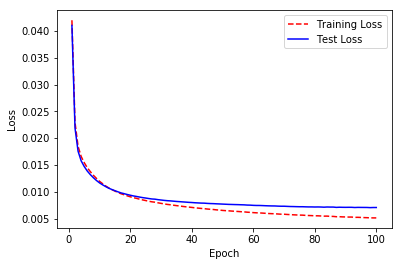

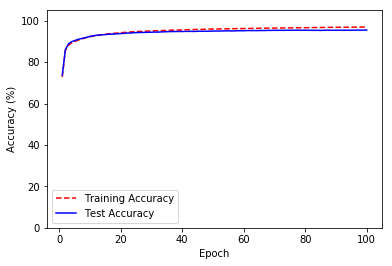

In [25]:
Plot_Loss_and_Accuracy(train_loss_plot_2_4, test_loss_plot_2_4, train_accuracy_plot_2_4, test_accuracy_plot_2_4)